<a href="https://colab.research.google.com/github/maceteligolden/NPL_TASK_2/blob/main/npl_text_classification_deep_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install keras_preprocessing

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 1.9 MB/s eta 0:00:00


Import all python libraries used for the work

In [53]:
import numpy as np
import tensorflow as tf
from keras_preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import SpatialDropout1D, Conv1D, MaxPooling1D, MultiHeadAttention,  Bidirectional,  Flatten, LSTM,  GRU, GlobalMaxPooling1D, Dense, Embedding, Input, Dropout, Attention, Concatenate, Embedding, GlobalAveragePooling1D
from tensorflow.keras.callbacks import EarlyStopping,  ModelCheckpoint, ReduceLROnPlateau
from transformers import TFAutoModel, AutoTokenizer, BertTokenizer, TFBertModel
import transformers
import itertools
import sys
from tensorflow.keras.regularizers import l2

Download NLTK stopwords

In [39]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

All constant used accross the work

In [40]:
stopwords = set(nltk.corpus.stopwords.words('english'))
training_dataset_path="/content/drive/MyDrive/dataset/olid-training-v1.0.tsv"
testing_dataset_path="/content/drive/MyDrive/dataset/testset-levela.tsv"
testing_label_path="/content/drive/MyDrive/dataset/labels-levela.csv"
GLOVE_EMB = '/content/glove.6B.300d.txt'
MODEL_PATH = '/content/drive/MyDrive/Colab Notebooks/text_classification_model.hdf5'
MAX_SEQUENCE_LENGTH = 30
EMBEDDING_DIM = 300
BATCH_SIZE = 32
EPOCHS = 10
LR = 1e-3

Download glove using wget and unzip the zipped file

In [12]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2024-08-01 08:31:01--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2024-08-01 08:31:01--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-08-01 08:31:01--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

Fetch dataset records using pandas

In [41]:
# Load dataset (adjust paths as needed)
training_dataset_path = "/content/drive/MyDrive/dataset/olid-training-v1.0.tsv"
data_set = pd.read_csv(training_dataset_path, delimiter='\t', encoding='utf-8')

Split data set 80% and 20% for training and validation respectively

In [56]:
train_data, test_data = train_test_split(data_set, test_size=0.2, random_state=7)
train_data.head()

,id,tweet,subtask_a,subtask_b,subtask_c
1263,26435,@USER @USER @USER I teach my grown sons theres...,OFF,TIN,IND
5046,91206,@USER I believe he is talented no matter what ...,NOT,NaN,NaN
11740,31739,***Non-Union Submissions*** Alex is currently ...,NOT,NaN,NaN
3145,62644,India Cuts Iranian Oil Imports Ahead of Novemb...,NOT,NaN,NaN
4315,33913,@USER Maybe they will Havana an Antifa race wa...,OFF,TIN,GRP


Plot data on histogram

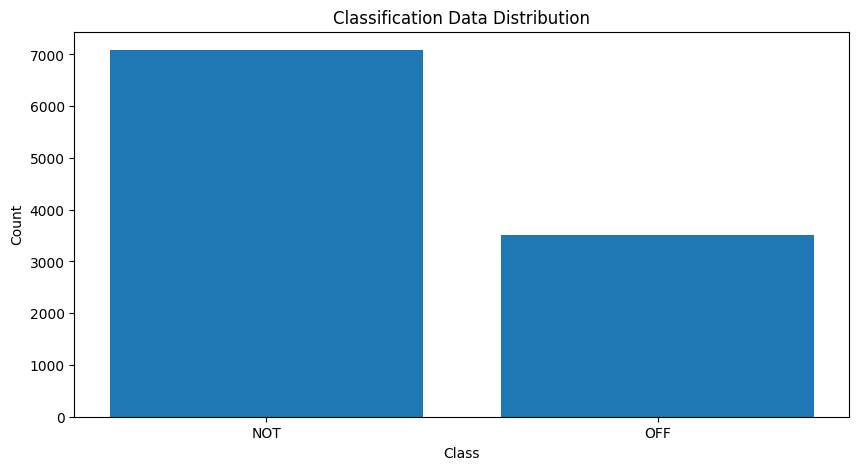

In [55]:
val_count = train_data["subtask_a"].value_counts()

plt.figure(figsize=(10,5))
plt.bar(val_count.index, val_count.values)
plt.title("Classification Data Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

Preprocess data using tokenization, cleaning and apply padding to have a constant matrix dimensions

In [57]:
# Preprocess data
train_tweets = train_data[['tweet', 'subtask_a']]
train_tweets["subtask_a"].replace({'OFF': 0, 'NOT': 1}, inplace=True)

test_tweets = test_data[['tweet', 'subtask_a']]
test_tweets["subtask_a"].replace({'OFF': 0, 'NOT': 1}, inplace=True)

# Text preprocessing function
def preprocess(text):
    text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

    text = re.sub("@USER", " ", text)

    text = re.sub("URL", " ", text)
    text = re.sub(text_cleaning_re, " ", str(text).lower()).strip()
    stopwords = set(nltk.corpus.stopwords.words('english'))
    tokens = [token for token in text.split() if token not in stopwords]
    return " ".join(tokens)

train_tweets.tweet = train_tweets.tweet.apply(preprocess)
test_tweets.tweet = test_tweets.tweet.apply(preprocess)

# Tokenization and padding
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_tweets.tweet)

word_index = tokenizer.word_index
vocab_size = len(word_index) + 1

x_train = pad_sequences(tokenizer.texts_to_sequences(train_tweets.tweet), maxlen=MAX_SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(test_tweets.tweet), maxlen=MAX_SEQUENCE_LENGTH)


<ipython-input-57-74ba5af4b62d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_tweets["subtask_a"].replace({'OFF': 0, 'NOT': 1}, inplace=True)
<ipython-input-57-74ba5af4b62d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_tweets["subtask_a"].replace({'OFF': 0, 'NOT': 1}, inplace=True)
<ipython-input-57-74ba5af4b62d>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 

Extract word embeddings

In [58]:
# Prepare labels
y_train = train_tweets.subtask_a.values
y_test = test_tweets.subtask_a.values

# Load GloVe embeddings
embedding_index = {}
with open(GLOVE_EMB) as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

# Prepare embedding matrix
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

sys.setrecursionlimit(10000)
reduce_lr = ReduceLROnPlateau(factor=0.1, min_lr=0.01, monitor='val_loss', verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

Train, test and display LSTM model results

In [63]:
# Define function to create LSTM model
def create_lstm_model():
    embedding_layer = tf.keras.layers.Embedding(
        vocab_size,
        EMBEDDING_DIM,
        weights=[embedding_matrix],
        input_length=MAX_SEQUENCE_LENGTH,
        trainable=False
    )

    sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    embedding_sequences = embedding_layer(sequence_input)
    x = SpatialDropout1D(0.2)(embedding_sequences)
    x = Conv1D(64, 5, activation='relu')(x)
    x = Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2))(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu')(x)
    outputs = Dense(1, activation='sigmoid')(x)
    model = tf.keras.Model(sequence_input, outputs)

    model.compile(optimizer=Adam(learning_rate=LR), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Training and evaluating LSTM model
lstm_model = create_lstm_model()

history_lstm = lstm_model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS,
                              validation_data=(x_test, y_test), callbacks=[reduce_lr, early_stopping])
lstm_model.summary()
y_pred_lstm = lstm_model.predict(x_test)
y_pred_lstm_1d = [1 if pred > 0.5 else 0 for pred in y_pred_lstm]

cnf_matrix = confusion_matrix(test_data.subtask_a.to_list(), y_pred_lstm_1d)
plt.figure(figsize=(6,6))
plot_confusion_matrix(cnf_matrix, classes=test_data.subtask_a.unique(), title="Confusion matrix")
plt.show()

print("LSTM Model Classification Report")
print(classification_report(y_test, y_pred_lstm_1d, target_names=['OFF', 'NOT']))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
331/331 ━━━━━━━━━━━━━━━━━━━━ 46s 108ms/step - accuracy: 0.6903 - loss: 0.5868 - val_accuracy: 0.7651 - val_loss: 0.5068 - learning_rate: 0.0010
Epoch 2/10
331/331 ━━━━━━━━━━━━━━━━━━━━ 26s 77ms/step - accuracy: 0.7760 - loss: 0.4758 - val_accuracy: 0.7711 - val_loss: 0.4908 - learning_rate: 0.0010
Epoch 3/10
331/331 ━━━━━━━━━━━━━━━━━━━━ 40s 74ms/step - accuracy: 0.7879 - loss: 0.4386 - val_accuracy: 0.7802 - val_loss: 0.4853 - learning_rate: 0.0010
Epoch 4/10
331/331 ━━━━━━━━━━━━━━━━━━━━ 45s 86ms/step - accuracy: 0.8215 - loss: 0.3927 - val_accuracy: 0.7655 - val_loss: 0.5119 - learning_rate: 0.0010
Epoch 5/10
331/331 ━━━━━━━━━━━━━━━━━━━━ 36s 71ms/step - accuracy: 0.8388 - loss: 0.3610 - val_accuracy: 0.7538 - val_loss: 0.5377 - learning_rate: 0.0010
Epoch 6/10
331/331 ━━━━━━━━━━━━━━━━━━━━ 39s 66ms/step - accuracy: 0.8759 - loss: 0.3044 - val_accuracy: 0.7640 - val_loss: 0.5531 - learning_rate: 0.0010


Model: "functional_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_38 (InputLayer)          │ (None, 30)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_36 (Embedding)             │ (None, 30, 300)             │       5,014,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d_24                 │ (None, 30, 300)             │               0 │
│ (SpatialDropout1D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_36 (Conv1D)                   │ (None, 26, 64)              │          96,064 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_24 (Bidirectional)     │ (None, 128)                 │          66,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_96 (Dense)                     │ (None, 512)                 │          66,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_45 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_97 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_98 (Dense)                     │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,488,489 (24.75 MB)

 Trainable params: 491,329 (1.87 MB)

 Non-trainable params: 5,014,500 (19.13 MB)

 Optimizer params: 982,660 (3.75 MB)

83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step


ValueError: Mix of label input types (string and number)

Train, test and display GRU model results

In [50]:
# Define function to create GRU model
def create_gru_model():
    embedding_layer = tf.keras.layers.Embedding(
        vocab_size,
        EMBEDDING_DIM,
        weights=[embedding_matrix],
        input_length=MAX_SEQUENCE_LENGTH,
        trainable=False
    )

    sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    embedding_sequences = embedding_layer(sequence_input)
    x = SpatialDropout1D(0.2)(embedding_sequences)
    x = Conv1D(64, 5, activation='relu')(x)
    x = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = Bidirectional(GRU(64, dropout=0.2, recurrent_dropout=0.2))(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu')(x)
    outputs = Dense(1, activation='sigmoid')(x)
    model = tf.keras.Model(sequence_input, outputs)
    optimizer = Adam(learning_rate=1e-4)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Training and evaluating GRU model
gru_model = create_gru_model()
history_gru = gru_model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS,validation_data=(x_test, y_test), callbacks=[reduce_lr, early_stopping])
gru_model.summary()
y_pred_gru = gru_model.predict(x_test)
y_pred_gru_1d = [1 if pred > 0.5 else 0 for pred in y_pred_gru]
print("GRU Model Classification Report")
print(classification_report(y_test, y_pred_gru_1d, target_names=['OFF', 'NOT']))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
331/331 ━━━━━━━━━━━━━━━━━━━━ 35s 85ms/step - accuracy: 0.6651 - loss: 1.2123 - val_accuracy: 0.7058 - val_loss: 1.0114 - learning_rate: 1.0000e-04
Epoch 2/10
331/331 ━━━━━━━━━━━━━━━━━━━━ 23s 68ms/step - accuracy: 0.7149 - loss: 0.9558 - val_accuracy: 0.7349 - val_loss: 0.8413 - learning_rate: 1.0000e-04
Epoch 3/10
331/331 ━━━━━━━━━━━━━━━━━━━━ 49s 92ms/step - accuracy: 0.7423 - loss: 0.7982 - val_accuracy: 0.7406 - val_loss: 0.7469 - learning_rate: 1.0000e-04


Model: "functional_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_32 (InputLayer)          │ (None, 30)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_30 (Embedding)             │ (None, 30, 300)             │       5,014,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d_19                 │ (None, 30, 300)             │               0 │
│ (SpatialDropout1D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_31 (Conv1D)                   │ (None, 26, 64)              │          96,064 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_78 (Dense)                     │ (None, 26, 64)              │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_19 (Bidirectional)     │ (None, 128)                 │          49,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_79 (Dense)                     │ (None, 512)                 │          66,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_37 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_80 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_81 (Dense)                     │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,452,885 (24.62 MB)

 Trainable params: 479,361 (1.83 MB)

 Non-trainable params: 5,014,800 (19.13 MB)

 Optimizer params: 958,724 (3.66 MB)

83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step
GRU Model Classification Report
              precision    recall  f1-score   support

         OFF       0.64      0.52      0.57       892
         NOT       0.78      0.85      0.81      1756

    accuracy                           0.74      2648
   macro avg       0.71      0.69      0.69      2648
weighted avg       0.73      0.74      0.73      2648



In [64]:
def create_attention_model(vocab_size, embedding_dim, max_sequence_length):
    input_seq = Input(shape=(max_sequence_length,), dtype='int32')

    embedding_layer = tf.keras.layers.Embedding(
        vocab_size,
        embedding_dim,
        input_length=max_sequence_length
    )(input_seq)

    attention_output = MultiHeadAttention(num_heads=8, key_dim=embedding_dim)(embedding_layer, embedding_layer)
    attention_output = Dropout(0.5)(attention_output)
    x = GlobalAveragePooling1D()(attention_output)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=input_seq, outputs=outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

attention_model = create_attention_model(vocab_size, EMBEDDING_DIM, MAX_SEQUENCE_LENGTH)

history = attention_model.fit(x_train, y_train, batch_size=32, epochs=EPOCHS, validation_data=(x_test, y_test), callbacks=[reduce_lr, early_stopping])

y_pred = attention_model.predict(x_test)
y_pred_1d = [1 if pred > 0.5 else 0 for pred in y_pred]
print("Attention Model Report")
print(classification_report(y_test, y_pred_1d, target_names=['OFF', 'NOT']))



/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
331/331 ━━━━━━━━━━━━━━━━━━━━ 454s 1s/step - accuracy: 0.6746 - loss: 0.6350 - val_accuracy: 0.7534 - val_loss: 0.5379 - learning_rate: 0.0010
Epoch 2/10
331/331 ━━━━━━━━━━━━━━━━━━━━ 497s 1s/step - accuracy: 0.8093 - loss: 0.4406 - val_accuracy: 0.7711 - val_loss: 0.5110 - learning_rate: 0.0010
Epoch 3/10
331/331 ━━━━━━━━━━━━━━━━━━━━ 527s 1s/step - accuracy: 0.8970 - loss: 0.2707 - val_accuracy: 0.7474 - val_loss: 0.7650 - learning_rate: 0.0010
83/83 ━━━━━━━━━━━━━━━━━━━━ 20s 241ms/step
Attention Model Report
              precision    recall  f1-score   support

         OFF       0.63      0.61      0.62       892
         NOT       0.80      0.82      0.81      1756

    accuracy                           0.75      2648
   macro avg       0.72      0.71      0.71      2648
weighted avg       0.75      0.75      0.75      2648

